# Resnet50+CBAM on  Cifar10 dataset

### **Step#1**: Import necessary libraries

In [34]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
#############################################
import tensorflow as tf
import keras
#################################
from keras.datasets import cifar10
from keras.utils import to_categorical
######################################
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K 
####################################
from keras.models import Model
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
####################################################
from models import resnet_v1 
from models.utils import lr_schedule
print("tensorflow_version",tf.__version__)
print("keras_version",keras.__version__)


tensorflow_version 2.15.0
keras_version 2.15.0


### **Step#2**: Load CIFAR-10 dataset and Split the data into training and testing sets

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [3]:
print("training Feature :", train_images.shape) 
print("training traject :", train_labels.shape) 
print("testing Feature :", test_images.shape) 
print("testing traject :", test_labels.shape) 

training Feature : (50000, 32, 32, 3)
training traject : (50000, 1)
testing Feature : (10000, 32, 32, 3)
testing traject : (10000, 1)


### **Step#3**: Visualize the CIFAR-10 dataset

In [4]:
labels_mapping = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck" ]

In [5]:
# Create a dictionary that maps each label to its index
label_to_index = {label: index for label,index in enumerate(labels_mapping)}
print(label_to_index)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


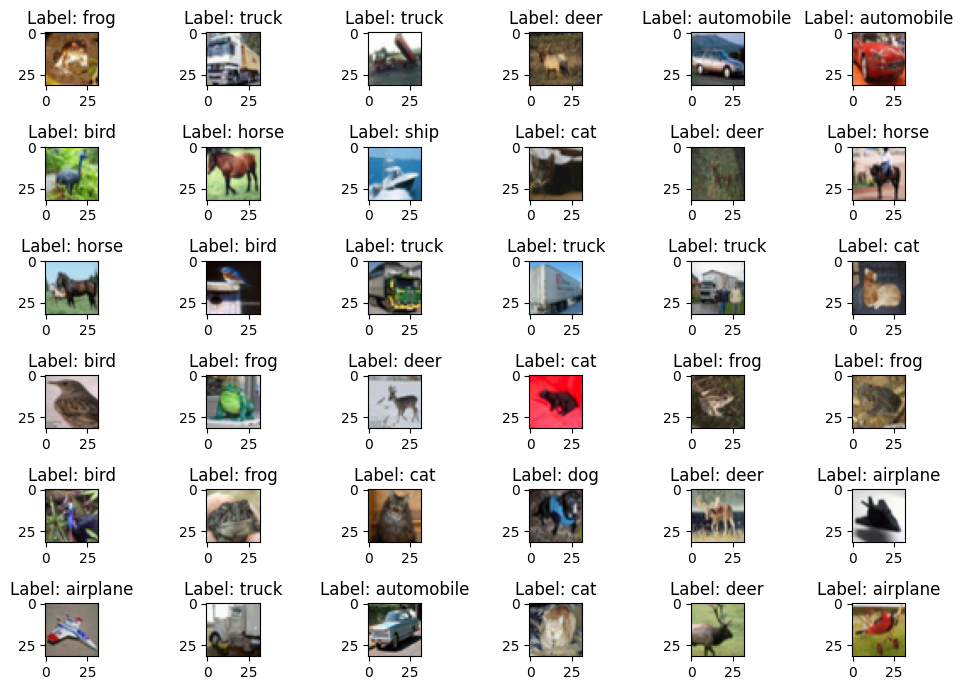

In [6]:
fig, ax = plt.subplots(6, 6, figsize=(10, 7)) 
k = 0
for i in range(6): 
    for j in range(6): 
        ax[i][j].imshow(train_images[k].reshape(32, 32,3))#, aspect='auto') 
        arr = np.array(train_labels[k]).item()
        label_for_index = label_to_index.get(arr, "Index not found")
        ax[i][j].set_title('Label: {}'.format(label_for_index))
        k += 1

plt.tight_layout()
plt.show()


### **Step#4**: Preprocess (normalize and one-hot encoded format) the Cifar10 data

In [7]:
def normalize_image(image):
    # Convert to floating-point values #img_float = (image.astype(np.float32))
    # Normalize pixel values to [0, 1]
    normalized_image = (image.astype(np.float32)) / 255.0

    return normalized_image 

In [8]:
# Normalize data.
train_images = normalize_image(train_images)
test_images=normalize_image(test_images)# Normalize pixel values to between 0 and 1
print(train_images)

[[[[0.23137255 0.24313726 0.24705882]
   [0.16862746 0.18039216 0.1764706 ]
   [0.19607843 0.1882353  0.16862746]
   ...
   [0.61960787 0.5176471  0.42352942]
   [0.59607846 0.49019608 0.4       ]
   [0.5803922  0.4862745  0.40392157]]

  [[0.0627451  0.07843138 0.07843138]
   [0.         0.         0.        ]
   [0.07058824 0.03137255 0.        ]
   ...
   [0.48235294 0.34509805 0.21568628]
   [0.46666667 0.3254902  0.19607843]
   [0.47843137 0.34117648 0.22352941]]

  [[0.09803922 0.09411765 0.08235294]
   [0.0627451  0.02745098 0.        ]
   [0.19215687 0.10588235 0.03137255]
   ...
   [0.4627451  0.32941177 0.19607843]
   [0.47058824 0.32941177 0.19607843]
   [0.42745098 0.28627452 0.16470589]]

  ...

  [[0.8156863  0.6666667  0.3764706 ]
   [0.7882353  0.6        0.13333334]
   [0.7764706  0.6313726  0.10196079]
   ...
   [0.627451   0.52156866 0.27450982]
   [0.21960784 0.12156863 0.02745098]
   [0.20784314 0.13333334 0.07843138]]

  [[0.7058824  0.54509807 0.3764706 ]
   [0.6

In [9]:
subtract_pixel_mean = True  # Subtracting pixel mean improves accuracy
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    train_train_mean = np.mean(train_images, axis=0)
    train_images -= train_train_mean
    test_images -= train_train_mean

In [10]:
train_labels = to_categorical(train_labels,10, dtype ="int32")  
test_labels = to_categorical(test_labels, 10,dtype ="int32")
print(train_labels)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


### **Step#5**: Development Define the Resnet+CBAM CNN model

#### 1) Define the ResNet+CBAM model architecture

In [11]:
# Training parameters
batch_size = 128
epochs = 200
depth = 50 # For ResNet, specify the depth (e.g. ResNet50: depth=50)
base_model = 'resnet'+str(depth)
# Choose what attention_module to use: cbam_block / se_block / None
attention_module = 'cbam_block'
model_type = base_model if attention_module==None else base_model+'_'+attention_module
print(model_type)
input_shape = train_images.shape[1:]
print(input_shape)
model_name = 'cifar10_%s_model' % model_type
print(model_name)


resnet50_cbam_block
(32, 32, 3)
cifar10_resnet50_cbam_block_model


In [12]:
# Input image dimensions.
resnet50CBAM_model = resnet_v1.resnet_v1(input_shape=input_shape, depth=depth, attention_module=attention_module)

In [13]:
resnet50CBAM_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])

Learning rate:  0.001


In [14]:
resnet50CBAM_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 16)           448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 16)           0         ['batch_normalization[0][0

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.662991 to fit



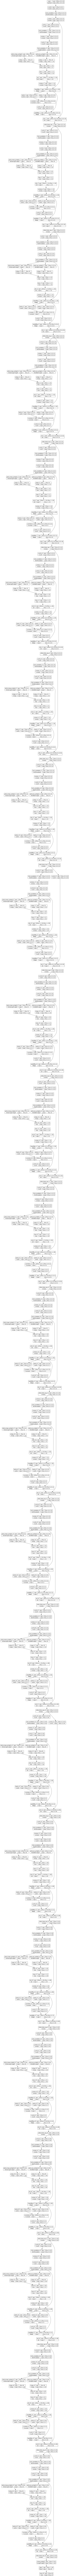

In [15]:
## Ensure the train and test directories exist
#os.makedirs(CNNmodel_dirPath, exist_ok=True)

import pydotplus.graphviz as gv

# Specify the GraphViz executable path
gv.find_graphviz()

# Now try to plot the model
from keras.utils import plot_model
plot_model(resnet50CBAM_model, to_file="saved_models\\"+str(model_name)+"_arch.png", show_shapes=True)


#### 2) callbacks and saving the model in hd5

In [16]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [17]:
# model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
# filepath = os.path.join(save_dir, model_name)
# Prepare callbacks for model saving and for learning rate adjustment.
# checkpoint = ModelCheckpoint(filepath=filepath,
#                             monitor='val_accuracy',
#                             verbose=1,
#                             save_best_only=True)

In [18]:
model_path="saved_models\\"+str(model_name)+".h5"
checkpointer = ModelCheckpoint(model_path, monitor='val_accuracy',verbose=1,save_best_only=True,
                        save_weights_only=False, mode='max',save_freq='epoch')


In [19]:
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


In [20]:
callbacks = [checkpointer, lr_reducer, lr_scheduler]

#### 3) Resnet+CBAM model training

In [21]:
training_resnet50CBAM_model=resnet50CBAM_model.fit(train_images, train_labels,batch_size=batch_size, epochs=epochs, validation_data=(test_images, test_labels), shuffle=True, callbacks=callbacks)

Learning rate:  0.001
Epoch 1/200



391/391 [==============================] - ETA: 0s - loss: 1.7475 - accuracy: 0.4866
Epoch 1: val_accuracy improved from -inf to 0.45410, saving model to saved_models\cifar10_resnet50_cbam_block_model.h5


c:\Users\SINES\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


391/391 [==============================] - 644s 1s/step - loss: 1.7475 - accuracy: 0.4866 - val_loss: 1.8160 - val_accuracy: 0.4541 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
391/391 [==============================] - ETA: 0s - loss: 1.2574 - accuracy: 0.6620
Epoch 2: val_accuracy improved from 0.45410 to 0.63200, saving model to saved_models\cifar10_resnet50_cbam_block_model.h5
391/391 [==============================] - 474s 1s/step - loss: 1.2574 - accuracy: 0.6620 - val_loss: 1.3389 - val_accuracy: 0.6320 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
391/391 [==============================] - ETA: 0s - loss: 1.0289 - accuracy: 0.7399
Epoch 3: val_accuracy improved from 0.63200 to 0.63250, saving model to saved_models\cifar10_resnet50_cbam_block_model.h5
391/391 [==============================] - 472s 1s/step - loss: 1.0289 - accuracy: 0.7399 - val_loss: 1.3846 - val_accuracy: 0.6325 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
391/391 [==============================] - ETA: 0

#### 4) Plotting a line chart to visualize the loss and accuracy values by epochs.


In [73]:
# train loss ##########################
train_loss = training_resnet50CBAM_model.history['loss']
print("train_loss",train_loss)
# train accuracy ##########################
train_accuracy = training_resnet50CBAM_model.history['accuracy']
print("train_accuracy",train_accuracy)

# validation loss ##########################
val_loss = training_resnet50CBAM_model.history['val_loss']
print("val_loss",val_loss)
# validation accuracy ##########################
val_accuracy = training_resnet50CBAM_model.history['val_accuracy']
print("val_accuracy",val_accuracy)


train_loss [1.7475018501281738, 1.2574447393417358, 1.028917670249939, 0.890827476978302, 0.7938916683197021, 0.7184354066848755, 0.6590556502342224, 0.6077841520309448, 0.5670062899589539, 0.5384006500244141, 0.5148715972900391, 0.4902174174785614, 0.46749502420425415, 0.4575958251953125, 0.443349152803421, 0.4308749735355377, 0.42815840244293213, 0.4208175241947174, 0.40682512521743774, 0.4132893681526184, 0.4003129005432129, 0.39416512846946716, 0.3951568305492401, 0.38828080892562866, 0.3936860263347626, 0.3848533630371094, 0.384727418422699, 0.3768392503261566, 0.37665855884552, 0.37904852628707886, 0.3718245327472687, 0.3764837384223938, 0.37125054001808167, 0.37057796120643616, 0.36545994877815247, 0.35898780822753906, 0.3633349537849426, 0.3609478175640106, 0.3639656603336334, 0.35550186038017273, 0.3585045635700226, 0.35826513171195984, 0.3511054813861847, 0.35778653621673584, 0.34470686316490173, 0.35505300760269165, 0.3461148142814636, 0.3508126139640808, 0.3454514443874359,

In [74]:
# train loss mean ##########################
train_loss_mean=sum(train_loss)/len(train_loss)
print("train_loss_mean:",train_loss_mean)
# train accuracy ##########################
train_accuracy_mean=sum(train_accuracy)/len(train_accuracy)
print("\ntrain_accuracy_mean:",train_accuracy_mean)

# validation loss ##########################
val_loss_mean=sum(val_loss)/len(val_loss)
print("\nval_loss_mean:",val_loss_mean)

# validation accuracy ##########################
val_accuracy_mean=sum(val_accuracy)/len(val_accuracy)
print("\nval_accuracy_mean:",val_accuracy_mean)
# Create a dictionary with the values
mean_history = {
    'train_loss_mean': [train_loss_mean],
    'train_accuracy_mean': [train_accuracy_mean],
    'val_loss_mean': [val_loss_mean],
    'val_accuracy_mean': [val_accuracy_mean]
}



train_loss_mean: 0.2292268181219697

train_accuracy_mean: 0.9776849976181984

val_loss_mean: 1.344115384221077

val_accuracy_mean: 0.7895544999837876


Text(0.5, 0.92, 'Lineplots showing training and validation loss of cifar10_resnet50_cbam_block_model by epochs')

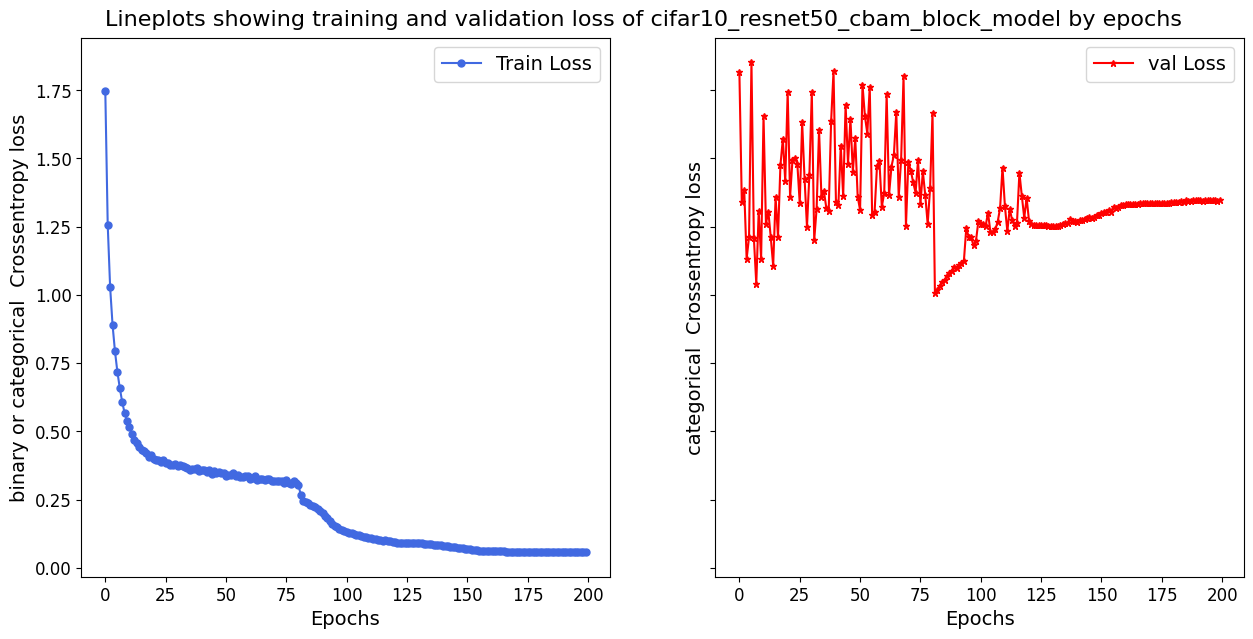

In [75]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.
# loss: 0.0690 - 
# accuracy: 1.0000 - 
# val_loss: 1.6341 - 
# val_accuracy: 0.7950 

fig, ax = plt.subplots(ncols=2, figsize=(15,7),sharex=True, sharey=True) 

ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
#ax[0].plot(val_loss, label='val Loss', color = 'orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel("binary or categorical  Crossentropy loss", fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
###################################################################
ax[1].plot(val_loss, label='val Loss', color = 'red', marker='*', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel("categorical  Crossentropy loss", fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
plt.savefig("saved_models\\"+str(model_name)+"_loss.png")
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing training and validation loss of "+str(model_name)+" by epochs", fontsize=16)

Text(0.5, 0.92, 'Lineplots showing training and validation accuracy of cifar10_resnet50_cbam_block_model by epochs')

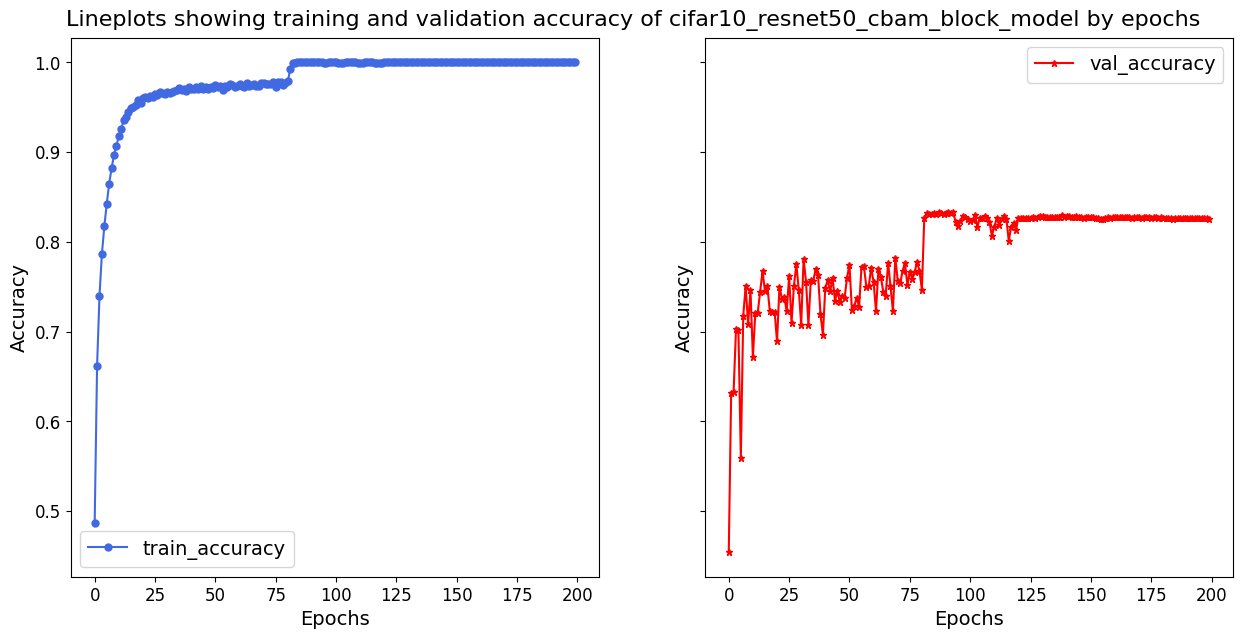

In [76]:
fig1, ax1 = plt.subplots(ncols=2, figsize=(15,7),sharex=True, sharey=True) 
ax1 = ax1.ravel()
ax1[0].plot(train_accuracy, label='train_accuracy', color='royalblue', marker='o', markersize=5)
ax1[0].set_xlabel('Epochs', fontsize=14)
ax1[0].set_ylabel('Accuracy', fontsize=14)
ax1[0].legend(fontsize=14)
ax1[0].tick_params(axis='both', labelsize=12)

###################################################################
ax1[1].plot(val_accuracy, label='val_accuracy', color = 'red', marker='*', markersize=5)
ax1[1].set_xlabel('Epochs', fontsize=14)
ax1[1].set_ylabel("Accuracy", fontsize=14)
ax1[1].legend(fontsize=14)
ax1[1].tick_params(axis='both', labelsize=12)
plt.savefig("saved_models\\"+str(model_name)+"_accuracy.png")
fig1.suptitle(x=0.5, y=0.92, t="Lineplots showing training and validation accuracy of "+str(model_name)+" by epochs", fontsize=16)

In [77]:
# Score trained model.
scores = resnet50CBAM_model.evaluate(test_images, test_labels, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
# Create a dictionary with the values
model_evalution = {
    'Test loss': [scores[0]],
    'Test accuracy': [scores[1]]
}


313/313 [==============================] - 13s 41ms/step - loss: 1.3488 - accuracy: 0.8258
Test loss: 1.3488081693649292
Test accuracy: 0.8258000016212463


### **Step#6**: save Resnet20+CBAM model and performance in cvs file with model

#### a) get the CNN model and performance metric

In [78]:

# Extracting architecture details
architecture = []

for layer in resnet50CBAM_model.layers:
    layer_type = layer.__class__.__name__
    layer_config = layer.get_config()
    architecture.append((layer_type, layer_config))

# Assuming you have model history containing metrics
trainModelhistory = training_resnet50CBAM_model.history
# Convert architecture to a DataFrame
architecture_df = pd.DataFrame(architecture, columns=['Layer Type', 'Layer Config'])
print(architecture_df)
# Convert history to a DataFrame
history_df = pd.DataFrame(trainModelhistory,index=range(1,epochs+1 ))
print(history_df)
# Create DataFrame from the dictionary
mean_history_df = pd.DataFrame(mean_history)
print(mean_history_df)

model_evalution_df=pd.DataFrame(model_evalution)
print(model_evalution_df)





             Layer Type                                       Layer Config
0            InputLayer  {'batch_input_shape': (None, 32, 32, 3), 'dtyp...
1                Conv2D  {'name': 'conv2d', 'trainable': True, 'dtype':...
2    BatchNormalization  {'name': 'batch_normalization', 'trainable': T...
3            Activation  {'name': 'activation', 'trainable': True, 'dty...
4                Conv2D  {'name': 'conv2d_1', 'trainable': True, 'dtype...
..                  ...                                                ...
508                 Add  {'name': 'add_47', 'trainable': True, 'dtype':...
509          Activation  {'name': 'refined_feature_map_24', 'trainable'...
510    AveragePooling2D  {'name': 'average_pooling2d', 'trainable': Tru...
511             Flatten  {'name': 'flatten', 'trainable': True, 'dtype'...
512               Dense  {'name': 'dense_48', 'trainable': True, 'dtype...

[513 rows x 2 columns]
         loss  accuracy  val_loss  val_accuracy            lr
1    1.747502 

#### b) save  CNN model and performance metric in the csv file 

In [79]:
# Creating summaryfile of model instance with different values
summaryfile= 'saved_models\\'+str(model_name)+".xlsx"

# Generating writer engine
writer = pd.ExcelWriter(summaryfile, engine='openpyxl')

# Adding dataframes to Excel as new sheets
architecture_df.to_excel(writer, sheet_name='ResNet50+CBAM_architecture', index=False)
history_df.to_excel(writer, sheet_name='training_log', index=True,index_label='Epoch')
mean_history_df.to_excel(writer, sheet_name='mean_training_log', index=False)
model_evalution_df.to_excel(writer, sheet_name='ResNet50+CBAM_model_evalution', index=False)
# Saving changes and closing writer
writer.book.save(summaryfile)#"modelsummary.xlsx")
writer.close()